<a href="https://colab.research.google.com/github/rodmart21/Sports_analytics/blob/main/Logistic_Regresion_Goal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # In this notebook, a dataset containing various variables is utilized to introduce into a model that will determine whether a shot is going to be goal or not.

## 1) Install requiered dependencies.

 It is neccesary to install this package from StatsBomb that allows us to the easy importation and manipulation of our data. Mplsoccer is desgined for an easiest representation of a football field.

In [1]:
%pip install statsbombpy
%pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 3.0 MB/s eta 0:00:00


In this links there is some information regarding the expected goals.

https://github.com/statsbomb/open-data
https://github.com/wswager/womens_soccer_expected_goals_model/blob/main/data_preprocessing/expected_goals_data_preprocessing_notebook.ipynb
https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/tree/master
https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html
https://www.youtube.com/watch?v=310_eW0hUqQ&ab_channel=FriendsofTracking
https://twitter.com/LanusStats/status/1456381238252605443
https://theanalyst.com/eu/2021/06/que-son-los-goles-esperados-xg/


Import requiered libraries

In [31]:
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

## 2) Preprocessing of data

Statsbomb has a database with so a large number of matches, making it possible to choose the one we prefer.

In [3]:
sb.competitions().head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-05-21T03:36:44.090970,2024-05-21T03:38:27.534702,2024-05-21T03:38:27.534702,2024-05-21T03:36:44.090970
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-28T18:02:23.493027,None,None,2024-02-28T18:02:23.493027
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-05-13T13:14:25.239651,2021-06-13T16:17:31.694,None,2024-05-13T13:14:25.239651
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [4]:
sb.competitions().shape

(72, 12)

Charge this dataframe with all the variables available so we can choose those considered more important for our model. It is possible to make websraping from football data from the internet, but in this case we just load the csv with the information we need.

In [6]:
shots_statsbomb = pd.read_csv('/content/tirosStatsBomb_modeloxG_v2.csv')

In [7]:
shots_statsbomb.shape

(22780, 119)

In [8]:
shots_statsbomb.head(2)

,Unnamed: 0.1,Unnamed: 0,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,goalkeeper_lost_in_play,pass_backheel,x,y,player_off_permanent,goalkeeper_lost_out,goalkeeper_success_out,half_end_early_video_end,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post
0,0,2674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,96.0,38.8,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,113.1,40.7,NaN,NaN,NaN,NaN,NaN,NaN


There are so many variables to analyze; only those considered relevant to our specific problem need to be taken into account. The first filter we establish is to conserve only those that contain the word 'shot'.

In [9]:
booleans = pd.Series(shots_statsbomb.columns).str.contains('shot')
df_test = pd.concat([pd.Series(shots_statsbomb.columns), booleans], axis=1)
df_test[df_test.iloc[:,1] == True]

,0,1
41,pass_assisted_shot_id,True
54,pass_shot_assist,True
67,shot_aerial_won,True
68,shot_body_part,True
69,shot_deflected,True
70,shot_end_location,True
71,shot_first_time,True
72,shot_freeze_frame,True
73,shot_key_pass_id,True
74,shot_one_on_one,True


So, these are the variables considered important for our use case.

In [10]:
shots_filt = shots_statsbomb[['shot_aerial_won',
'shot_body_part',
'shot_first_time',
'shot_deflected',
'shot_one_on_one',
'shot_open_goal',
'shot_outcome',
'shot_technique',
'shot_type',
'play_pattern',
'x',
'y'
]].reset_index(drop=True)

There are three types of variables: categorical, boolean, and personalized. We are going to build a couple of the last ones: first, the distance to the center of the goal and the angle between the shot and both posts. The formula to calculate the angle is not trivial, you can check this link to get more information: https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760

In [11]:
shots_filt['goal'] = np.where(shots_filt.shot_outcome == 'Goal', 1,0)
shots_filt['Distance'] = np.sqrt(np.square(120-shots_filt['x']) + np.square(40 - shots_filt['y']))
shots_filt['angulo'] = np.arctan(7.32 *shots_filt['x'] /(shots_filt['x']**2 + shots_filt['y']**2 - (7.32/2)**2))
shots_filt.shot_aerial_won = shots_filt.shot_aerial_won.fillna(False)  # Replaces a NaN value with False
shots_filt.shot_first_time = shots_filt.shot_first_time.fillna(False)
shots_filt.shot_one_on_one = shots_filt.shot_one_on_one.fillna(False)
shots_filt.shot_open_goal = shots_filt.shot_open_goal.fillna(False)
shots_filt.shot_deflected = shots_filt.shot_open_goal.fillna(False)
shots_filt.head()

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_outcome,shot_technique,shot_type,play_pattern,x,y,goal,Distance,angulo
0,False,Left Foot,True,False,False,False,Blocked,Half Volley,Open Play,From Kick Off,96.0,38.8,0,24.029981,0.065531
1,False,Left Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,113.1,40.7,0,6.935416,0.057292
2,False,Right Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,103.8,41.9,0,16.311039,0.060630
3,False,Head,False,False,False,False,Off T,Normal,Open Play,From Corner,112.2,36.8,0,8.430896,0.058893
4,False,Left Foot,False,False,False,False,Post,Normal,Open Play,Regular Play,97.8,51.5,0,25.001800,0.058595


Let's make a quick representation of all shots from inside the box.

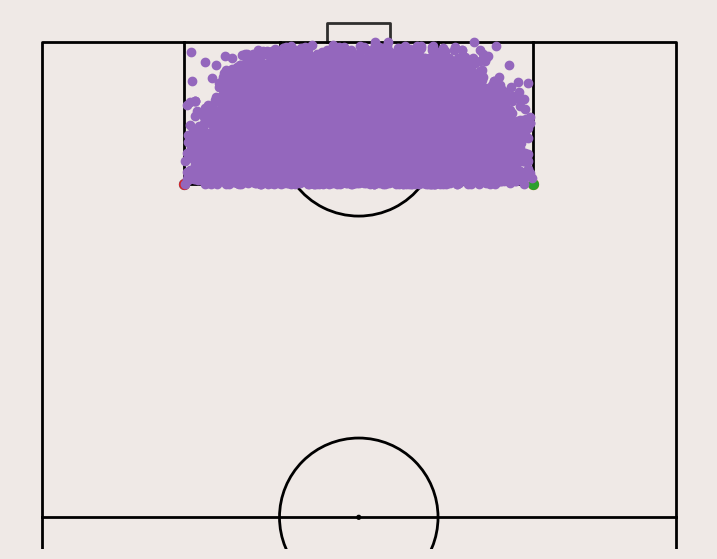

In [12]:
fig,ax = plt.subplots(figsize=(10,7))
facecolor='#EFE9E6'
fig.set_facecolor(facecolor)
pitch=VerticalPitch(pitch_type='statsbomb',goal_type='box',goal_alpha=.8, pitch_color=facecolor, line_color= 'black', half=True)
pitch.draw(ax=ax)

pitch.scatter(102,18,ax=ax,s=50)
pitch.scatter(102,62,ax=ax,s=50)
pitch.scatter(102,62,ax=ax,s=50)
pitch.scatter(102,18,ax=ax,s=50)

shots_filt['area']= np.where((shots_filt['x']>102) & (shots_filt['y']> 18) & (shots_filt['y']< 62), True, False)
pitch.scatter(shots_filt[shots_filt['area']== True].x, shots_filt[shots_filt['area']== True].y, ax=ax)

The most common correlation coefficient calculated by corr() is Pearson's correlation coefficient. This coefficient measures the strength and direction of the linear relationship between two variables. Values close to 1: Indicate that as one variable increases, the other tends to increase as well (strong positive correlation).
Values close to -1: Indicate that as one variable increases, the other tends to decrease (strong negative correlation).
Values close to 0: Indicate that there is no strong linear relationship between the variables.

In [13]:
shots_filt[['shot_aerial_won','shot_first_time','shot_one_on_one']].corr()

,shot_aerial_won,shot_first_time,shot_one_on_one
shot_aerial_won,1.000000,-0.206638,-0.004640
shot_first_time,-0.206638,1.000000,-0.159175
shot_one_on_one,-0.004640,-0.159175,1.000000


It is interesting to see the correlation between different variables, in this case there is no relevant correlation

The categorical variables have been transformed into dummy variables. The important variables are then selected. The columns shot_outcome and play_pattern are eliminated as they are not considered to be interesting.

In [14]:
shots_filt_dum = pd.get_dummies(shots_filt, columns=['shot_body_part', 'shot_technique', 'shot_type'])
shots_filt_dum= shots_filt_dum[['shot_aerial_won', 'shot_first_time', 'shot_deflected',
       'shot_one_on_one', 'shot_open_goal','x', 'y', 'goal', 'Distance', 'angulo', 'area', 'shot_body_part_Head',
       'shot_body_part_Left Foot', 'shot_body_part_Other','shot_body_part_Right Foot', 'shot_technique_Backheel',
       'shot_technique_Diving Header', 'shot_technique_Half Volley','shot_technique_Lob', 'shot_technique_Normal',
       'shot_technique_Overhead Kick', 'shot_technique_Volley','shot_type_Corner', 'shot_type_Free Kick', 'shot_type_Open Play','shot_type_Penalty']]

In [15]:
shots_filt_dum.head(2)

,shot_aerial_won,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,x,y,goal,Distance,angulo,...,shot_technique_Diving Header,shot_technique_Half Volley,shot_technique_Lob,shot_technique_Normal,shot_technique_Overhead Kick,shot_technique_Volley,shot_type_Corner,shot_type_Free Kick,shot_type_Open Play,shot_type_Penalty
0,False,True,False,False,False,96.0,38.8,0,24.029981,0.065531,...,False,True,False,False,False,False,False,False,True,False
1,False,True,False,False,False,113.1,40.7,0,6.935416,0.057292,...,False,True,False,False,False,False,False,False,True,False


In [25]:
shots_filt_dum= shots_filt_dum.dropna()

## 3) Model development

A supervised machine learning model is used. A typical example is Logistic Regression. It is a simple model, but it usually returns good results. The target categories are not balanced, that's why we introduce the parameter: *class_weight='balanced'*.

In [26]:
y = shots_filt_dum['goal']
X = shots_filt_dum.drop(columns=['goal'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)

In [27]:
y.value_counts()

goal
0    20291
1     2488
Name: count, dtype: int64

### 3.1) Introducing *class_weight='balanced'* to compensate the misbalanced in the categories.

This code builds and tunes a logistic regression model using cross-validated grid search to find the optimal hyperparameters, while ensuring data standardization and handling class imbalance. The model is trained and the hyperparameters found.

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))])

param_grid = {
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


Once the model is trained, we need to take the test data and check how well it is performing. The accuracy measures the correct ones over all the positive predictions (compares with the column inside the confusion matrix). The recall the positive predictions over the true positive values (compares with the row). The f1-score is just the armonic mean between both of them

Accuracy: 0.7311237928007024
Confusion Matrix: 
[[2992 1066]
 [ 159  339]]


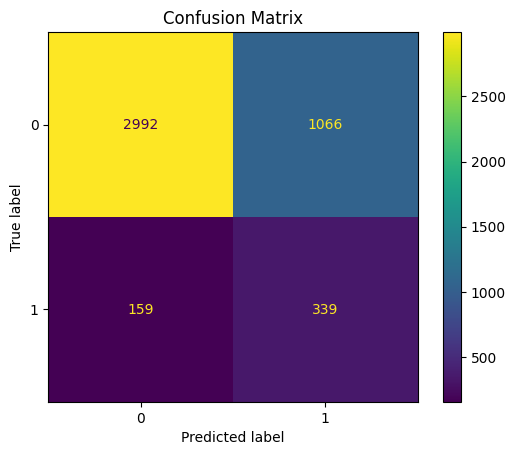

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      4058
           1       0.24      0.68      0.36       498

    accuracy                           0.73      4556
   macro avg       0.60      0.71      0.59      4556
weighted avg       0.87      0.73      0.78      4556



In [29]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cm}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred)
print(f"Classification Report: \n{class_report}")

### 3.2) Using SMOTE to create artificial data.

This techniques completes the data from the minority class with artificial values.

In [ ]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=13)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))])

param_grid = {
    'logreg__solver': ['liblinear', 'saga'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Study the performance:

Best parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Accuracy: 0.8175534143276079
Confusion Matrix: 
[[3613  643]
 [ 228  290]]


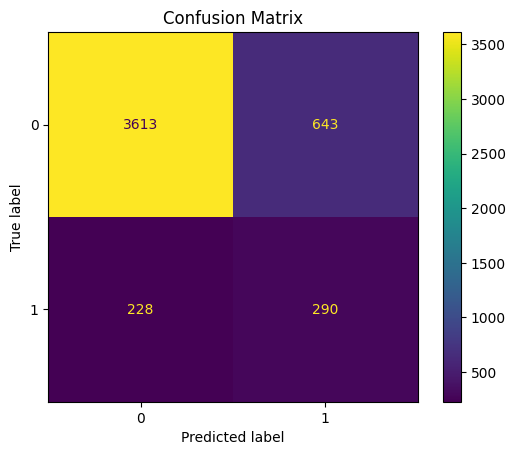

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4256
           1       0.31      0.56      0.40       518

    accuracy                           0.82      4774
   macro avg       0.63      0.70      0.65      4774
weighted avg       0.87      0.82      0.84      4774



In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cm}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
class_report = classification_report(y_test, y_pred)
print(f"Classification Report: \n{class_report}")


### 3.3) Random UnderSampler.

Using the Random UnderSampler library for the undersampled class.

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=13)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Accuracy: 0.7346041055718475
Confusion Matrix: 
[[3136 1120]
 [ 147  371]]


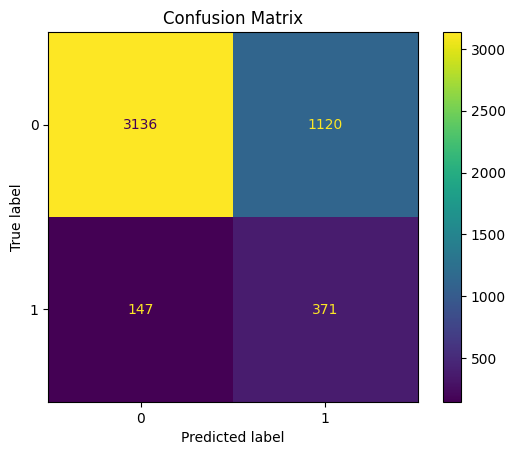

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.74      0.83      4256
           1       0.25      0.72      0.37       518

    accuracy                           0.73      4774
   macro avg       0.60      0.73      0.60      4774
weighted avg       0.88      0.73      0.78      4774



In [28]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cm}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred)
print(f"Classification Report: \n{class_report}")

### 3.4) Random Forest.

Using a more complicated model like Random Forest.

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=13))
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Accuracy: 0.8912861332216171
Confusion Matrix: 
[[4139  117]
 [ 402  116]]


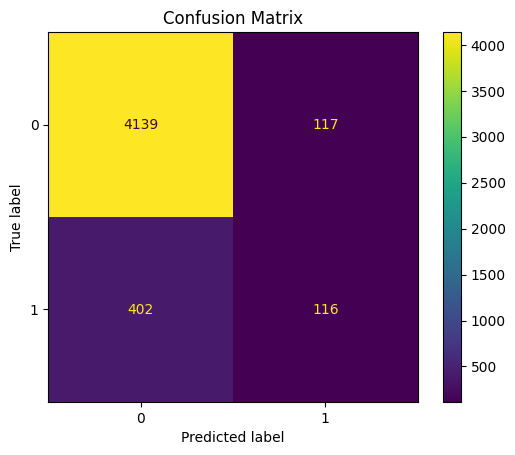

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4256
           1       0.50      0.22      0.31       518

    accuracy                           0.89      4774
   macro avg       0.70      0.60      0.62      4774
weighted avg       0.87      0.89      0.87      4774



In [29]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{cm}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, y_pred)
print(f"Classification Report: \n{class_report}")

### 4) Validation

A visual validation of the results can be made and check the probability in every specific case.